### Libs

In [1]:
from tqdm import tqdm
import numpy as np
import os
import random
import glob
import re
from pathlib import Path

import cv2
import geopandas as gpd
import pandas as pd
import shapely.speedups

import albumentations as A

import gc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import BCEWithLogitsLoss
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
import segmentation_models_pytorch as smp
from torchvision.utils import make_grid, save_image
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
from pytorch_model_summary import summary
from sklearn.metrics import f1_score, confusion_matrix, classification_report

import model
import metrics
import config
import utis
import train_val_test

from matplotlib import pyplot as plt, cm
import plotly.express as px
import plotly.graph_objects as go
import plotly

plotly.offline.init_notebook_mode() # avoiding saving html files


from torch.utils.data import DataLoader, random_split
from dataset import HistoricalImagesDataset
import config

# Ignore excessive warnings
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

# WandB – Import the wandb library
import wandb

import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2

### Weights and Biases

In [36]:
!wandb login 

wandb: Currently logged in as: vibferreira (use `wandb login --relogin` to force relogin)


### Custom Split Dataset

In [2]:
# Paths
IMAGES_PATH = '../data/patches/images/1942'
MASK_PATH = '../data/patches/masks/1942'
BEST_MODEL = '../best_model'

FILTER_PATH = '../data/geopackages/patch_keys.gpkg'
TILE_PATH = '../data/geopackages/tiles.gpkg'
TEST_DATASET_PATH = '../data/test_dataset'

image_paths = glob.glob(IMAGES_PATH +'/*.tif')
mask_paths = glob.glob(MASK_PATH +'/*.tif')

In [3]:
geo_df = gpd.read_file(FILTER_PATH) # contains the idxs with a selection of non-noisy and noisy data
tile_df = gpd.read_file(TILE_PATH) # split tile 

In [4]:
def split_by_tile(FILTER_PATH:str, 
                  TILE_PATH:str, 
                  IMG_PATH:str, 
                  MASK_PATH:str, 
                  keep_df:bool = False):
    
    ''' Split data by geographical tile.
    Args:
    FILTER_PATH (str): path to the patch keys in gpkg
    TILE_PATH (str) : path to the tiles in gpkg
    IMG_PATH (str) : path to the image
    MASK_PATH (str) : path to the mask
    keep_df (bool) : choose if df should be returned
    ''' 
    
    # read gpkgs 
    geo_df = gpd.read_file(FILTER_PATH) # contains the patch keys
    tile_df = gpd.read_file(TILE_PATH) # split tile 
    
    tile_df['split'] = None
    random.seed(25)
    # create a split column dividing each polygon tile intro train test and split  
    tile_df['split'] = tile_df['split'].apply(lambda x: random.choices(['train', 'val', 'test'], weights=[65, 15, 5])[0])
    print(tile_df['split'])

    # # keep only the patches that intersect the tiles 
    # # source https://gis.stackexchange.com/questions/375407/geopandas-intersects-doesnt-find-any-intersection
    inp, res = tile_df.sindex.query_bulk(geo_df.geometry, predicate='intersects') # inp are the idxs from the patches that intersects the tile and res the idxs of the tiles
    geo_df['intersects'] = np.isin(np.arange(0, len(geo_df)), inp)

    # # filter only patches that intersect the tiles
    inter_patches = geo_df.query('intersects == True')

    # # set the tile idx 
    inter_patches['tile_idx'] = res

    # # join patches and tile to keep the split 
    joined_df = inter_patches.merge(tile_df.reset_index(), left_on='tile_idx', right_on='index')

    # select patches paths based on train, val test values from the DF
    splits = np.unique(joined_df.split)
    dic_to_save = {'msk': {i: None for i in splits}, 
                  'img': {i: None for i in splits}}
    for i in splits:
        # select rows based on the split condition
        rows = joined_df.loc[joined_df['split'] == str(i)]['index_x']

        # filter patches 
        patchs = utis.filtered_paths(IMG_PATH, list(rows))
        masks = utis.filtered_paths(MASK_PATH, list(rows))

        # save in dictionary
        dic_to_save['img'].update({i: patchs})
        dic_to_save['msk'].update({i: masks})
        
    if keep_df:
        return dic_to_save, joined_df
    else:
        return dic_to_save

In [7]:
dic_to_save, joined_df = split_by_tile(FILTER_PATH, TILE_PATH, image_paths, mask_paths, keep_df=True)
X_test, X_train, X_val = dic_to_save['img']['test'], dic_to_save['img']['train'], dic_to_save['img']['val']
y_test, y_train, y_val = dic_to_save['msk']['test'], dic_to_save['msk']['train'], dic_to_save['msk']['val']

0     train
1       val
2       val
3     train
4       val
5     train
6     train
7      test
8     train
9     train
10    train
11    train
Name: split, dtype: object


/share/etud/e2008984/miniconda3/envs/torch_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [6]:
joined_df.rename(columns = {'geometry_x': 'geometry'}, inplace=True)
joined_df.columns
df = joined_df[['geometry', 'split']]

<AxesSubplot:>

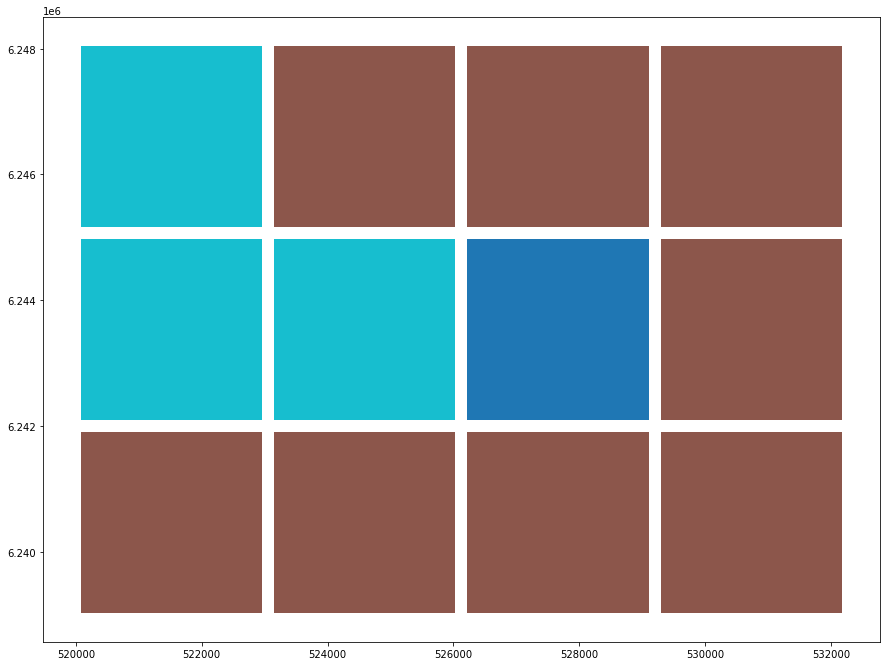

In [7]:
fig, ax = plt.subplots(figsize=(15, 15))
# inter_patches.plot(ax=ax, alpha=0.7, column='tile_idx')
gpd.GeoDataFrame(df).plot(ax=ax, column = 'split')

In [7]:
# # Read file 
# geo_df = gpd.read_file(FILTER_PATH) # contains the idxs with a selection of non-noisy and noisy data
# # geo_df['status'] = geo_df.apply(lambda x: 2 if x['index'] in [302, 365, 606, 895, 298, 698] else x['status'], axis=1) # correcting wrongly attributed category
# # geo_df['status'] = geo_df.apply(lambda x: np.NaN if x['index'] in [3083] else x['status'], axis=1) # correcting wrongly attributed category

# # Define the filters 
# filters = {
#        'non_veg_idxs' : geo_df.query("status == 0")['index'],
#        'veg_idxs' :  geo_df.query("status == 1")['index'], 
#        'mixed': geo_df.query("status == 2")['index'], 
#        'single_trees_idx' : geo_df.query("status == 3")['index'], 
#        'hedgerows' : geo_df.query("status == 4")['index'], 
#        #'coarse_to_very_coarse': geo_df.query("status == 5")['index'][5:]
#           }

# # fix bug of the test_size
# data_portion = 'all_coarse_labels' # ['all_coarse_labels','coarse_plus_fine_labels', 'fine_labels', 'coarse_labels']
# n_patches = 283
# X_train, y_train, X_val, y_val, X_test, y_test = utis.custom_split(filters, test_size=40, 
#                                                                    image_paths=image_paths, 
#                                                                    mask_paths=mask_paths,  
#                                                                    data_portion=data_portion,
#                                                                    DEST_PATH = TEST_DATASET_PATH,
#                                                                    number_training_patchs=n_patches)

In [6]:
## FOR ADAPTING THE NEW TEST DATASET
# list_to_remove = [2385, 2737, 2374, 763, 1861, 1644]
# list_to_add = [299, 1477, 3154, 2633, 1597, 1335]
# new_X_test = []
# new_y_test = []

# for x, y in zip(X_test, y_test):
#     to_remove = int(utis.get_file_index(x))
#     if not np.isin(to_remove, list_to_remove):
#         new_X_test.append(x)
#         new_y_test.append(y)
        
# for x, y in zip(image_paths, mask_paths):
#     to_add = int(utis.get_file_index(x))
#     if np.isin(to_add, list_to_add):
#         new_X_test.append(x)
#         new_y_test.append(y)       
    
# X_test = new_X_test
# y_test = new_y_test

In [7]:
# [int(utis.get_file_index(i))for i in X_test]

In [8]:
# exclude = list(filters['non_veg_idxs']) + list(filters['veg_idxs']) + list(filters['mixed'])
# save = []
                                                                                                   
# for x in X_test:
#     x_1 = utis.get_file_index(x)
    
#     if np.isin(x_1, list(filters['non_veg_idxs'])):
#         save.append(x_1)
        
# X_test = utis.filtered_paths(image_paths, save)
# y_test = utis.filtered_paths(mask_paths, save)

### Dataloader

In [8]:
# Define transformations
val_transform = A.Compose(
    [A.Normalize(mean=(0.512), std=(0.167)),
    ToTensorV2()])

train_transform = A.Compose([
      A.Rotate(limit=40,p=0.9, border_mode=cv2.BORDER_CONSTANT), # p stands for the probability with which the transformations are applied
      A.HorizontalFlip(p=0.9),
      A.VerticalFlip(p=0.9), 
      A.Transpose(p=0.9),
      A.CLAHE(p=1),
      A.Normalize(mean=(0.512), std=(0.167)),
      ToTensorV2()])

# Datasets
train_dataset = HistoricalImagesDataset(X_train, y_train, transform=train_transform, split_type=None)
val_dataset = HistoricalImagesDataset(X_val, y_val, transform=val_transform, split_type=None)
test_dataset = HistoricalImagesDataset(X_test, y_test, transform=val_transform, split_type='test')

data = next(iter(train_dataset))
print('shape train image', data[0].shape, 'shape train mask', data[1].shape) 

# Dataloader
print("Training set size: ", len(train_dataset))
train_dataloader = DataLoader(dataset=train_dataset, batch_size = config.BATCH_SIZE, shuffle=True)
print("Validation set size: ", len(val_dataset))
val_dataloader = DataLoader(dataset=val_dataset, batch_size = config.BATCH_SIZE, shuffle=True)

print("Testing set size: ", len(test_dataset))
test_dataloader = DataLoader(dataset=test_dataset, batch_size = 1)

shape train image torch.Size([1, 256, 256]) shape train mask torch.Size([256, 256])
Training set size:  1800
Validation set size:  675
Testing set size:  225


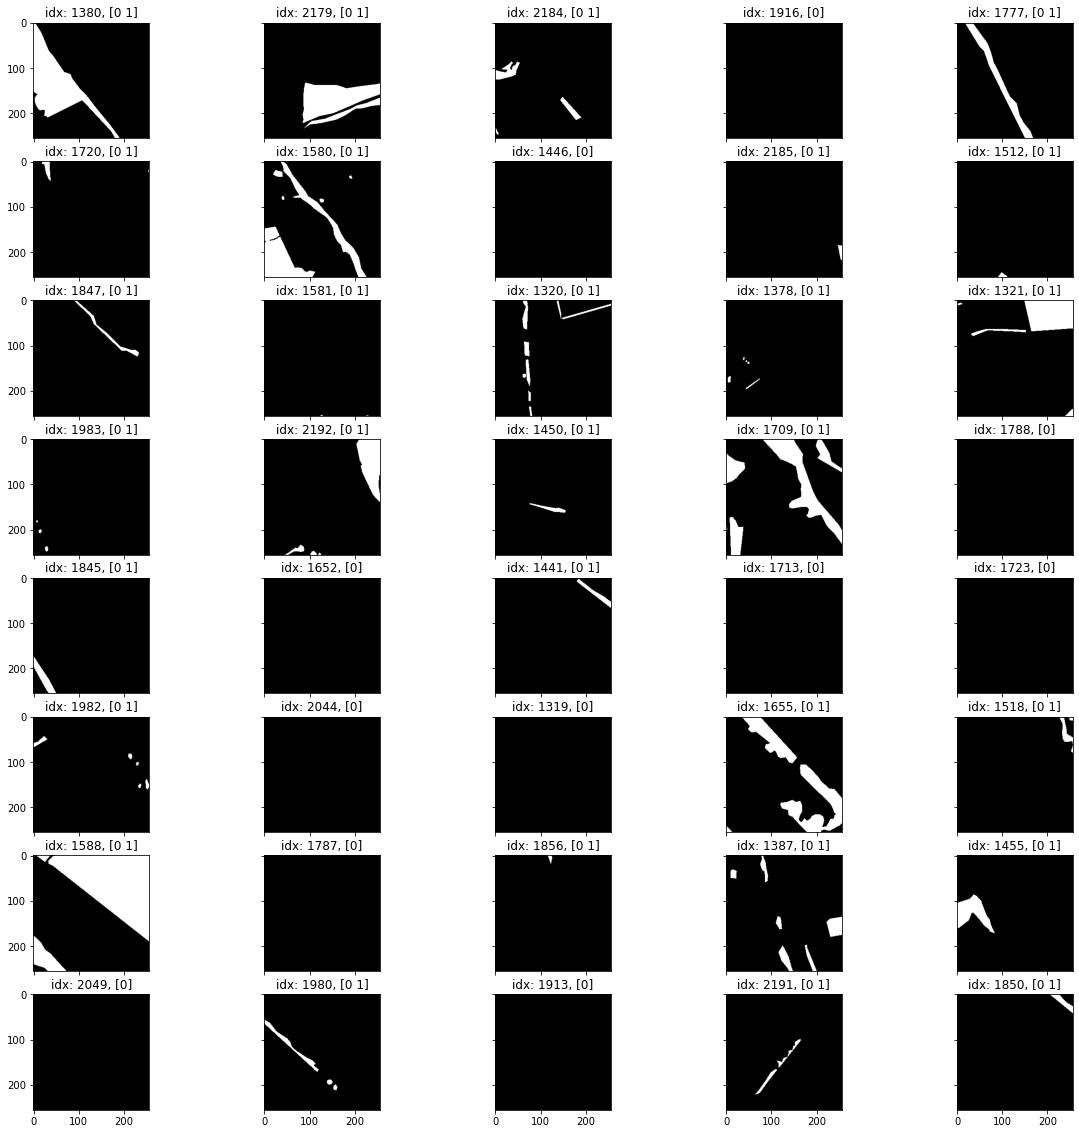

In [10]:
# Plot
n_col = 5
n_row = 8

_, axs = plt.subplots(n_row, n_col, figsize=(20,20), sharex=True, sharey=True)
axs = axs.flatten()
cmap = cm.get_cmap('gray')
# random.Random(4).shuffle(y_test)
# random.Random(4).shuffle(X_test)

for c, (i, ax) in enumerate(zip(y_test, axs)):
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    ax.imshow(img, cmap=cmap, vmin=0)
    ax.set_title(f'idx: {utis.get_file_index(i)}, {np.unique(img)}')
plt.show()

### Data Distribuition

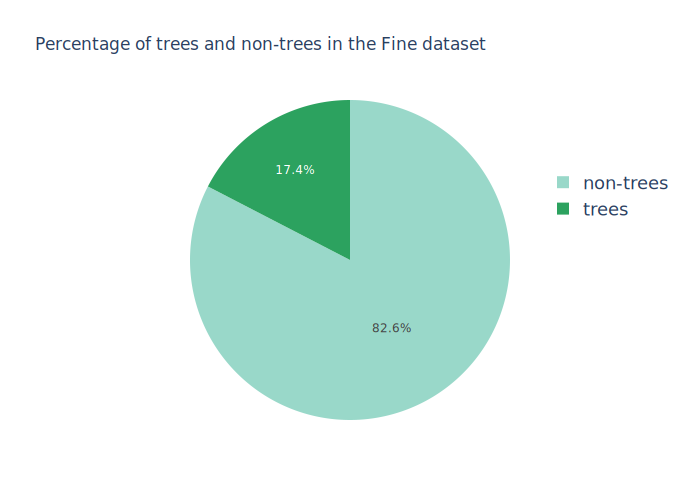

In [11]:
fig = utis.plot_pizza(y_val + y_test + y_train, title='Fine dataset')
# fig.write_image("FINE_dist_pixels_TOTAL.svg", format='svg', engine='kaleido', width=1700, height=775)

In [12]:
# filters
filters = {
       'non-trees' : geo_df.query("status == 0")['index'],
       'trees' :  geo_df.query("status == 1")['index'], 
       'mixed': geo_df.query("status == 2")['index'], 
       'hedgerows' : geo_df.query("status == 4")['index'], 
       'individual trees' : geo_df.query("status == 3")['index'], 
       #'coarse_to_very_coarse': geo_df.query("status == 5")['index'][5:]
          }

# train_val dataset
msks = y_test + y_train + y_val

# define the categories
categories = list(filters.keys())

dic={}
for cat in categories:
    y_dataset = utis.filtered_paths(msks, filters[cat])
    
    # calculate percentage of pixels per category
    f_counts = utis.count_data_dist(y_dataset)
    # store in the dict
    dic.update({cat: f_counts})    
    # store in the dict 

In [13]:
df = pd.DataFrame(dic)
df = df.melt() # invert axis 
df['label'] = ['non-trees','trees', 'non-trees','trees', 'non-trees','trees', 'non-trees','trees', 'non-trees','trees'] # name accordingly 

df['value'].iloc[0] = df['value'].iloc[0] + df['value'].iloc[1]
df['value'].iloc[1] = 0
df['value'].iloc[3] = df['value'].iloc[2] + df['value'].iloc[3]
df['value'].iloc[2] = 0

df['rate'] = df.groupby('variable').transform(lambda x: (x/x.sum())*100) # calculate the percentage
df['rate'] = df['rate'].apply(lambda x: round(x,3)) # calculate the percentage

df

/share/etud/e2008984/miniconda3/envs/torch_env/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



variable      value      label     rate
0         non-trees  4390912.0  non-trees  100.000
1         non-trees        0.0      trees    0.000
2             trees        0.0  non-trees    0.000
3             trees  4194304.0      trees  100.000
4             mixed   981960.0  non-trees   17.423
5             mixed  4654136.0      trees   82.577
6         hedgerows  5814869.0  non-trees   93.398
7         hedgerows   411051.0      trees    6.602
8  individual trees  5794668.0  non-trees   93.073
9  individual trees   431252.0      trees    6.927

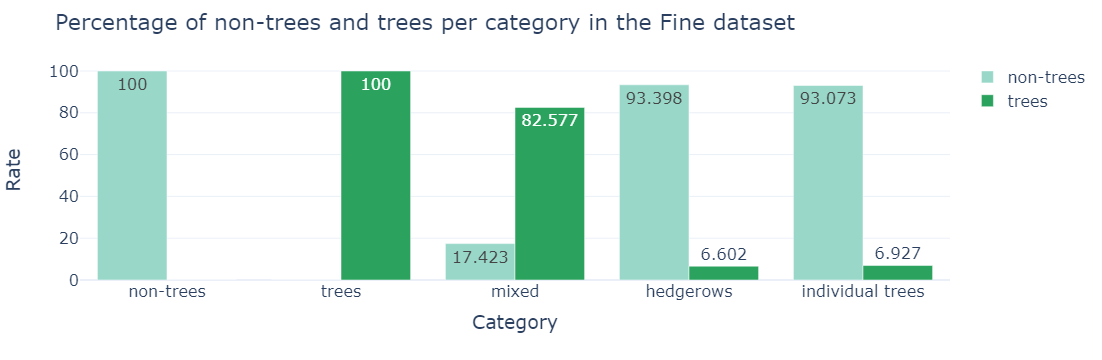

In [14]:
# Plotting it 
fig = px.bar(df, x="variable", y="rate",
         color='label', barmode='group',
         height=400,
         template="plotly_white",
         text_auto=True,
         color_discrete_map={
            "non-trees": "#99d8c9",
            "trees": "#2ca25f"})

fig.update_layout(
    title = 'Percentage of non-trees and trees per category in the Fine dataset',
    xaxis_title=f"Category",
    yaxis_title="Rate",
    legend_title="",
    font=dict(size=16))

fig.show()
fig.write_image("FINE_dist_pixels_per_class.svg", format='svg', engine='kaleido', width=1700, height=775)

### Check if CUDA is available

In [15]:
config.DEVICE

'cuda'

### MAIN

In [17]:
# WandB – Initialize a new run
# wandb.init(entity="vibferreira", project="master_thesis")

# classes
classes = ('no_vegetation', 'vegetation')

# Initialize model
unet = model.unet_model.to(config.DEVICE)

# initialize loss function and optimizer
lossFunc = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

opt = optim.Adam(unet.parameters(), lr=config.LR)
# opt = optim.SGD(unet.parameters(), lr=config.LR, momentum=0.95, weight_decay=0.01)
# scheduler = ReduceLROnPlateau(opt, mode='max', factor=0.1, patience=10, verbose=True)
scheduler = StepLR(opt, step_size=20, gamma=0.1)

# initialize a dictionary to store TRAINING history (keep track on training)
training_history = {"avg_train_loss": [], "train_accuracy": [], "IoU":[],"f1score":[], "avgDice":[]}

# # initialize a dictionary to store VALIDATION history (keep track on VALIDATION)
validation_history = {"avg_val_loss": [], "val_accuracy": [], "IoU_val":[], "f1score_val":[]}

# Using log="all" log histograms of parameter values in addition to gradients
# wandb.watch(unet, log="all")

# Autocasting 
scaler = GradScaler()

# initialize best accuracy
best_accuracy = 0.0
print(f'''Training the network for {config.NUM_EPOCHS} epochs, with a batch size of {config.BATCH_SIZE}''') # try with logger

# loop = tqdm(range(config.NUM_EPOCHS))
iter_ = 0
for e in range(config.NUM_EPOCHS):
    trained = train_val_test.train(unet, train_dataloader, opt, lossFunc, epoch=e, scaler=scaler, training_history=training_history)
    validated = train_val_test.validation(unet, val_dataloader, lossFunc, epoch=e, validation_history=validation_history)
    scheduler.step()
    
    # Save best model
    if validated['IoU_val'][-1] > best_accuracy and e > 10: # maybe add a minimum number of epochs as conditions
        utis.save_best_model(unet, BEST_MODEL, validated, e, data_portion, rate_of_coarse_labels=n_patches)
        best_accuracy = validation_history['IoU_val'][-1]

Training the network for 100 epochs, with a batch size of 16


Training Epoch [26/100]:   8%| | 11/135 [00:02<00:34,  3.55it/s, acc=0.9392252, dice=0.8641114, iou=0.760IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



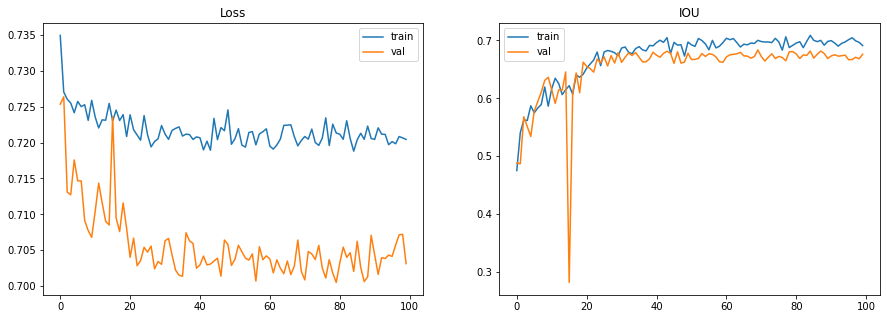

In [18]:
_, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(training_history["avg_train_loss"], label= 'train')
ax[0].plot(validation_history['avg_val_loss'], label='val')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(training_history['IoU'], label= 'train')
ax[1].plot(validation_history['IoU_val'], label='val')
ax[1].set_title('IOU')
ax[1].legend()
plt.show()

In [19]:
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)
# print('Attention type: ', config.ATT)
# unet = unet = model.unet_model.to(config.DEVICE)
# x = torch.zeros((1, 1, 256, 256))
# x = x.to(config.DEVICE)
# print(summary(unet, x, show_input=True, batch_size=config.BATCH_SIZE))

### KFold models Evaluation

In [20]:
# exclude = list(filters['non_veg_idxs']) + list(filters['veg_idxs']) + list(filters['mixed'])
# save = []
                                                                                                   
# for x in X_test:
#     x_1 = utis.get_file_index(x)
    
#     if not np.isin(x_1, exclude):
#         save.append(x_1)
        
# X_test = utis.filtered_paths(image_paths, save)
# y_test = utis.filtered_paths(mask_paths, save)
# test_dataset = HistoricalImagesDataset(X_test, y_test, transform=val_transform, split_type='test')
# test_dataloader = DataLoader(dataset=test_dataset, batch_size = 1)

In [11]:
# df = pd.DataFrame(means, index=['h', 'j'])
my_file = Path('../best_model/coarse_sizes')
my_file_2 = Path('../best_model/fine_sizes')

# means on the kfold test set
fine_df = utis.get_DF_with_the_means(my_file_2, label='kfold') 
coarse_df = utis.get_DF_with_the_means(my_file, label='kfold') 

# means on the independent test set
fine_df_idp = utis.get_DF_with_the_means(my_file_2, 
                                         label='independent_test_set', 
                                         independent_test=True, 
                                         test_dataloader=test_dataloader, 
                                         X_test=X_test)

coarse_df_idp = utis.get_DF_with_the_means(my_file, 
                                           label='independent_test_set', 
                                           independent_test=True, 
                                           test_dataloader=test_dataloader, 
                                           X_test=X_test)

# final_df = pd.concat([fine_df, coarse_df, fine_df_idp, coarse_df_idp])
# # # final_df = pd.concat([fine_df, coarse_df])
# final_df  = final_df[final_df['N_PATCHES'] != 411]

KeyboardInterrupt: 

In [22]:
final_df = pd.concat([fine_df_idp, coarse_df_idp])
final_df  = final_df[final_df['N_PATCHES'] != 411]
final_df = final_df.query("DATA_PORTION == ['coarse_independent_test_set', 'fine_independent_test_set'] ")
final_df['DATA_PORTION'] = final_df['DATA_PORTION'].apply(lambda x : 'Mean Fine Model' if x == 'fine_independent_test_set' else 'Mean Coarse Model')
final_df

N_PATCHES       IOU   STD_DEV       DATA_PORTION
8          20  0.355006  0.068441    Mean Fine Model
2          55  0.659605  0.160136    Mean Fine Model
4          90  0.689512  0.093594    Mean Fine Model
3         125  0.718112  0.156571    Mean Fine Model
1         160  0.852791  0.049794    Mean Fine Model
6         195  0.882235  0.014492    Mean Fine Model
9         230  0.892883  0.013731    Mean Fine Model
10        265  0.902611  0.008836    Mean Fine Model
11        300  0.903026  0.006853    Mean Fine Model
5         335  0.906647  0.022013    Mean Fine Model
0         370  0.876577  0.024298    Mean Fine Model
7          20  0.515938  0.103445  Mean Coarse Model
2          55  0.724014  0.079323  Mean Coarse Model
4          90  0.707578  0.044580  Mean Coarse Model
3         125  0.697459  0.139789  Mean Coarse Model
1         160  0.743684  0.112710  Mean Coarse Model
6         195  0.831037  0.016678  Mean Coarse Model
8         230  0.845549  0.019519  Mean Coarse Model
9         265  0.866093  0.012303  Mean Coarse Model
10        300  0.871874  0.012525  Mean Coarse Model
5         335  0.858528  0.015884  Mean Coarse Model
0         370  0.875090  0.005920  Mean Coarse Model

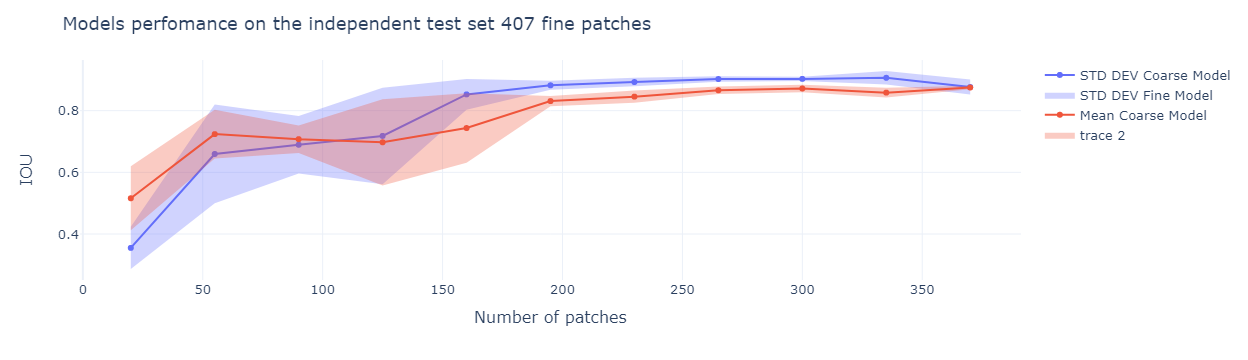

In [23]:
# final_df = final_df.query("DATA_PORTION == ['coarse_independent_test_set', 'fine_independent_test_set'] ")
# final_df['DATA_PORTION'] = final_df['DATA_PORTION'].apply(lambda x : 'Mean Fine Model' if x == 'fine_independent_test_set' else 'Mean Coarse Model')

fig = utis.line(
    data_frame = final_df,
    x = 'N_PATCHES',
    y = 'IOU',
    error_y = 'STD_DEV',
    error_y_mode = 'band', # Here you say `band` or `bar`.
    color = 'DATA_PORTION',
    markers = '.',
    # labels={'fine_kfold': "Mean IOU Fine Model", 'coarse_kfold': "Mean IOU Coarse Model"},
    template="plotly_white",
    
)

fig.update_layout(
    title = f'Models perfomance on the independent test set {len(X_test)} fine patches',
    xaxis_title="Number of patches",
    yaxis_title=" IOU",
    legend_title="",
    font=dict(size=13))
    
fig.show()

In [24]:
fig.write_image("IOU_X_N_Patches.svg", format='svg', engine='kaleido', width=1700, height=775)

### Predictions

../best_model/unet/all_coarse_labels_epoch_63_iou_0.680_acc_0.961.pth
['../saved_images/masks/masks_224_id_1715.tif']


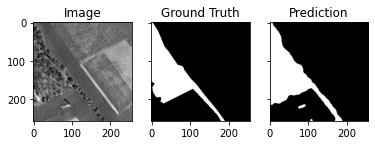

<Figure size 432x288 with 0 Axes>

Saving patch_0_id_1380.tif


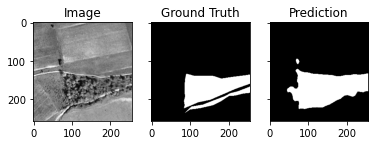

<Figure size 432x288 with 0 Axes>

Saving patch_1_id_2179.tif


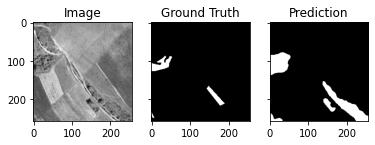

<Figure size 432x288 with 0 Axes>

Saving patch_2_id_2184.tif


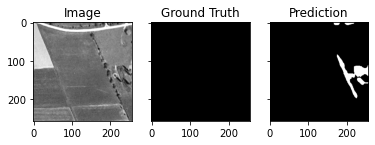

<Figure size 432x288 with 0 Axes>

Saving patch_3_id_1916.tif


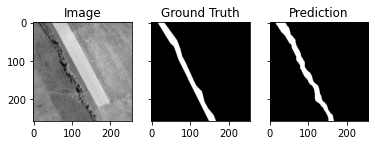

<Figure size 432x288 with 0 Axes>

Saving patch_4_id_1777.tif


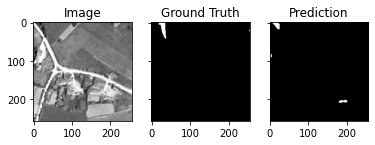

<Figure size 432x288 with 0 Axes>

Saving patch_5_id_1720.tif


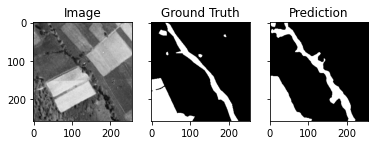

<Figure size 432x288 with 0 Axes>

Saving patch_6_id_1580.tif


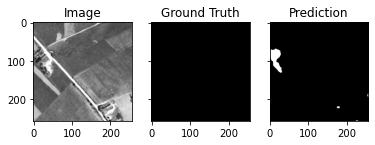

<Figure size 432x288 with 0 Axes>

Saving patch_7_id_1446.tif


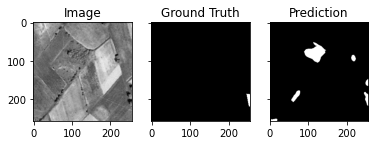

<Figure size 432x288 with 0 Axes>

Saving patch_8_id_2185.tif


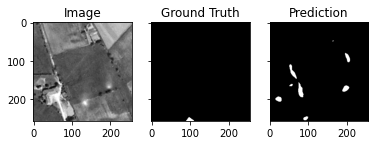

<Figure size 432x288 with 0 Axes>

Saving patch_9_id_1512.tif


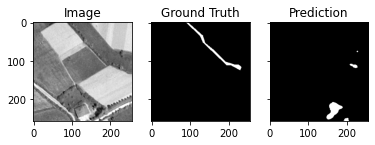

<Figure size 432x288 with 0 Axes>

Saving patch_10_id_1847.tif


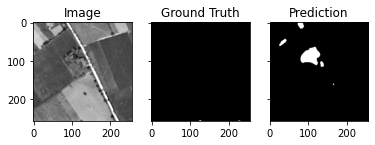

<Figure size 432x288 with 0 Axes>

Saving patch_11_id_1581.tif


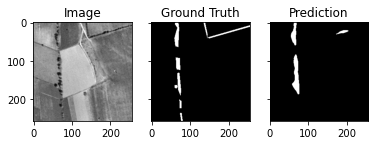

<Figure size 432x288 with 0 Axes>

Saving patch_12_id_1320.tif


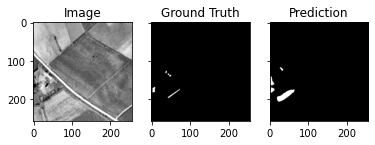

<Figure size 432x288 with 0 Axes>

Saving patch_13_id_1378.tif


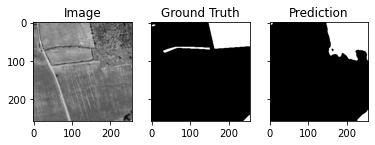

<Figure size 432x288 with 0 Axes>

Saving patch_14_id_1321.tif


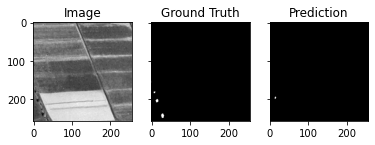

<Figure size 432x288 with 0 Axes>

Saving patch_15_id_1983.tif


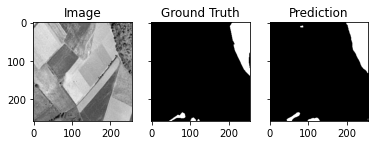

<Figure size 432x288 with 0 Axes>

Saving patch_16_id_2192.tif


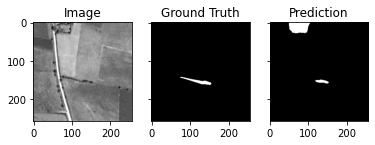

<Figure size 432x288 with 0 Axes>

Saving patch_17_id_1450.tif


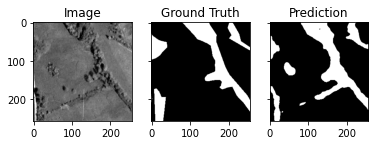

<Figure size 432x288 with 0 Axes>

Saving patch_18_id_1709.tif


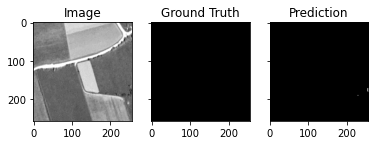

<Figure size 432x288 with 0 Axes>

Saving patch_19_id_1788.tif


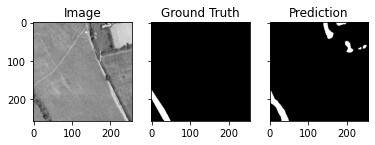

<Figure size 432x288 with 0 Axes>

Saving patch_20_id_1845.tif


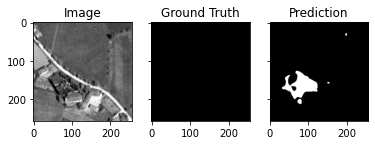

<Figure size 432x288 with 0 Axes>

Saving patch_21_id_1652.tif


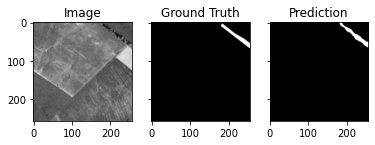

<Figure size 432x288 with 0 Axes>

Saving patch_22_id_1441.tif


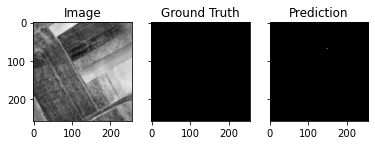

<Figure size 432x288 with 0 Axes>

Saving patch_23_id_1713.tif


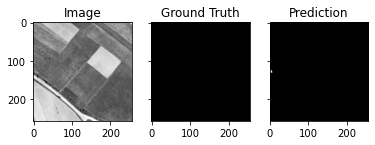

<Figure size 432x288 with 0 Axes>

Saving patch_24_id_1723.tif


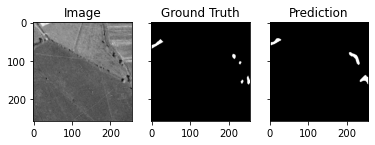

<Figure size 432x288 with 0 Axes>

Saving patch_25_id_1982.tif


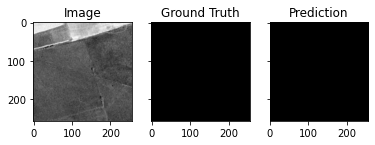

<Figure size 432x288 with 0 Axes>

Saving patch_26_id_2044.tif


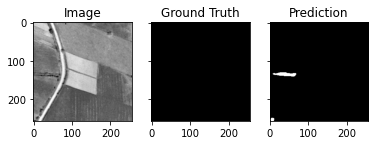

<Figure size 432x288 with 0 Axes>

Saving patch_27_id_1319.tif


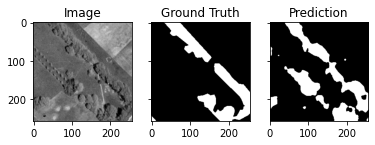

<Figure size 432x288 with 0 Axes>

Saving patch_28_id_1655.tif


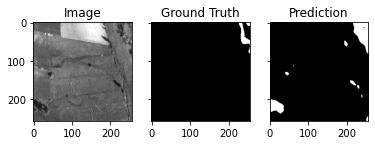

<Figure size 432x288 with 0 Axes>

Saving patch_29_id_1518.tif


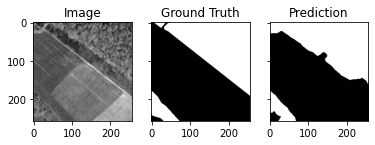

<Figure size 432x288 with 0 Axes>

Saving patch_30_id_1588.tif


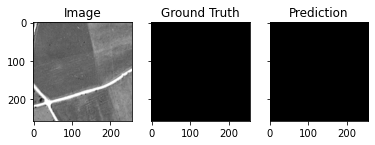

<Figure size 432x288 with 0 Axes>

Saving patch_31_id_1787.tif


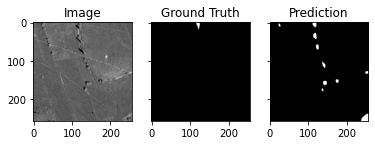

<Figure size 432x288 with 0 Axes>

Saving patch_32_id_1856.tif


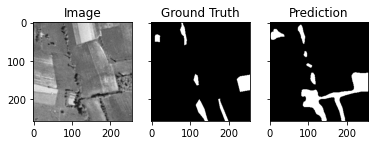

<Figure size 432x288 with 0 Axes>

Saving patch_33_id_1387.tif


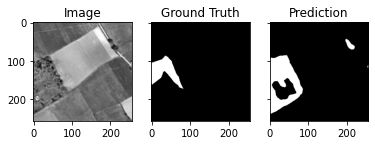

<Figure size 432x288 with 0 Axes>

Saving patch_34_id_1455.tif


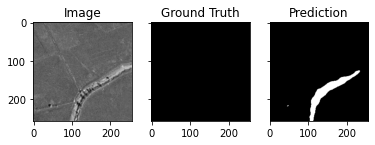

<Figure size 432x288 with 0 Axes>

Saving patch_35_id_2049.tif


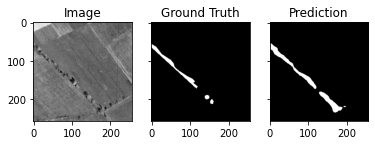

<Figure size 432x288 with 0 Axes>

Saving patch_36_id_1980.tif


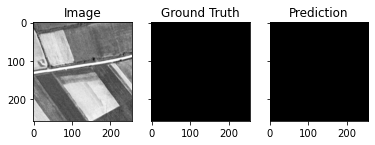

<Figure size 432x288 with 0 Axes>

Saving patch_37_id_1913.tif


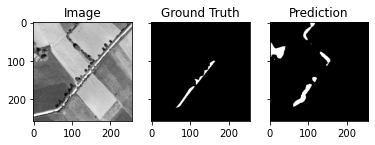

<Figure size 432x288 with 0 Axes>

Saving patch_38_id_2191.tif


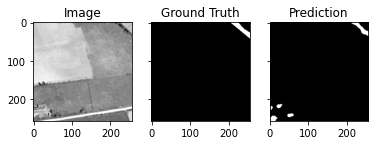

<Figure size 432x288 with 0 Axes>

Saving patch_39_id_1850.tif


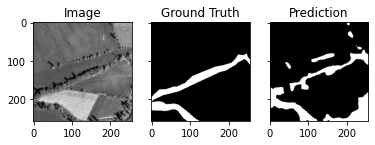

<Figure size 432x288 with 0 Axes>

Saving patch_40_id_1920.tif


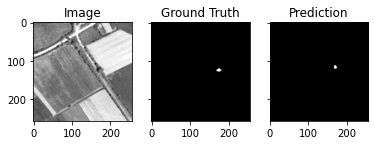

<Figure size 432x288 with 0 Axes>

Saving patch_41_id_1914.tif


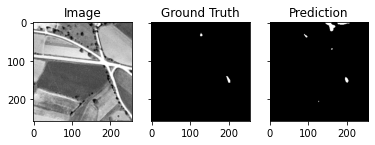

<Figure size 432x288 with 0 Axes>

Saving patch_42_id_2257.tif


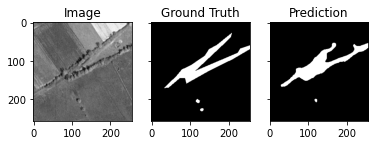

<Figure size 432x288 with 0 Axes>

Saving patch_43_id_1981.tif


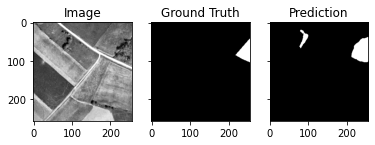

<Figure size 432x288 with 0 Axes>

Saving patch_44_id_1309.tif


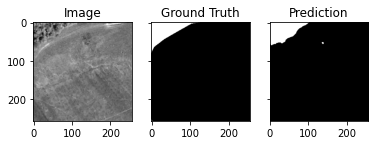

<Figure size 432x288 with 0 Axes>

Saving patch_45_id_1313.tif


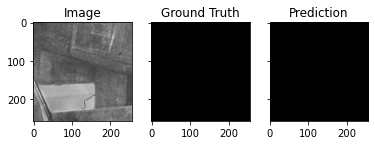

<Figure size 432x288 with 0 Axes>

Saving patch_46_id_1453.tif


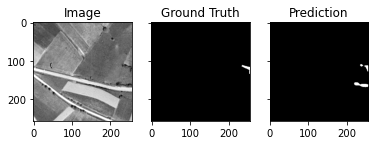

<Figure size 432x288 with 0 Axes>

Saving patch_47_id_2258.tif


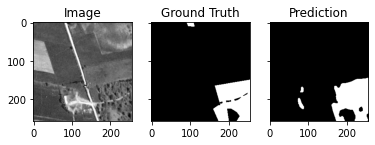

<Figure size 432x288 with 0 Axes>

Saving patch_48_id_1579.tif


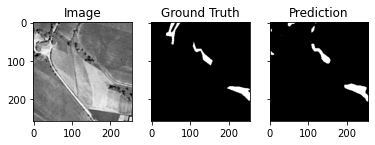

<Figure size 432x288 with 0 Axes>

Saving patch_49_id_2189.tif


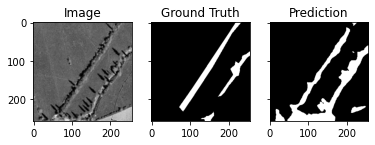

<Figure size 432x288 with 0 Axes>

Saving patch_50_id_1986.tif


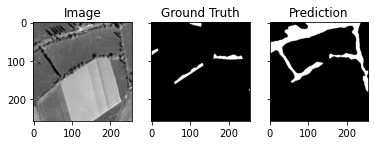

<Figure size 432x288 with 0 Axes>

Saving patch_51_id_1987.tif


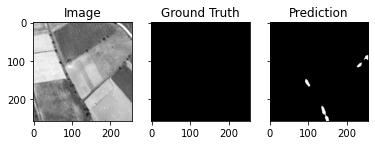

<Figure size 432x288 with 0 Axes>

Saving patch_52_id_1445.tif


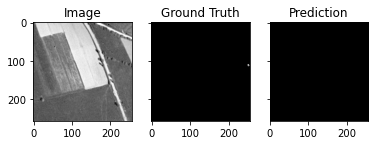

<Figure size 432x288 with 0 Axes>

Saving patch_53_id_1790.tif


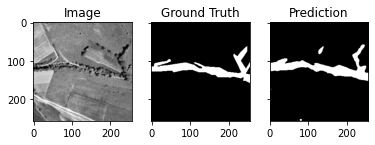

<Figure size 432x288 with 0 Axes>

Saving patch_54_id_2121.tif


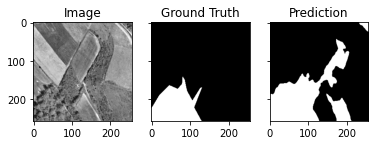

<Figure size 432x288 with 0 Axes>

Saving patch_55_id_2251.tif


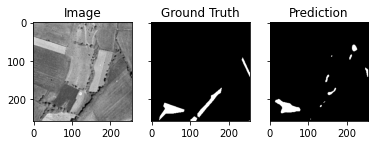

<Figure size 432x288 with 0 Axes>

Saving patch_56_id_2057.tif


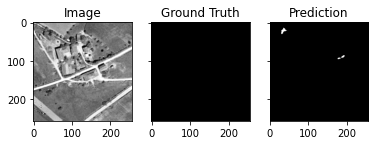

<Figure size 432x288 with 0 Axes>

Saving patch_57_id_2255.tif


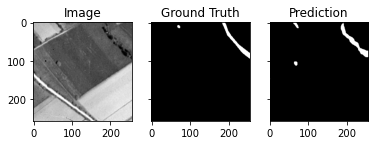

<Figure size 432x288 with 0 Axes>

Saving patch_58_id_1717.tif


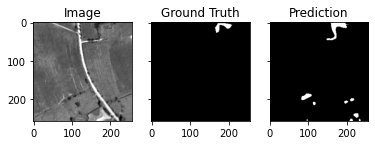

<Figure size 432x288 with 0 Axes>

Saving patch_59_id_1584.tif


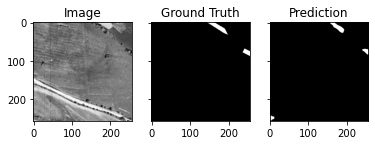

<Figure size 432x288 with 0 Axes>

Saving patch_60_id_2187.tif


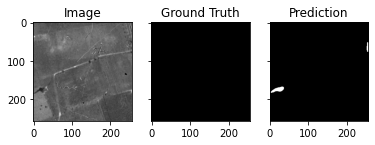

<Figure size 432x288 with 0 Axes>

Saving patch_61_id_1585.tif


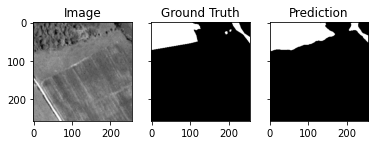

<Figure size 432x288 with 0 Axes>

Saving patch_62_id_1647.tif


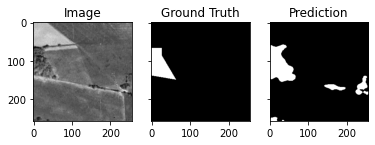

<Figure size 432x288 with 0 Axes>

Saving patch_63_id_1511.tif


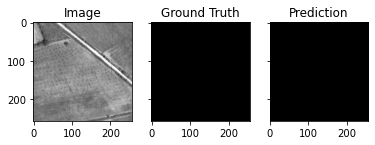

<Figure size 432x288 with 0 Axes>

Saving patch_64_id_1846.tif


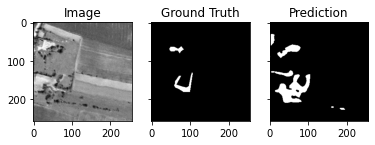

<Figure size 432x288 with 0 Axes>

Saving patch_65_id_1386.tif


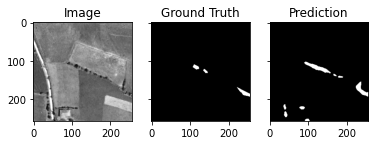

<Figure size 432x288 with 0 Axes>

Saving patch_66_id_1383.tif


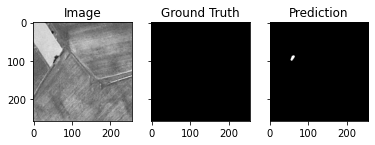

<Figure size 432x288 with 0 Axes>

Saving patch_67_id_2178.tif


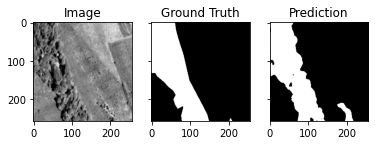

<Figure size 432x288 with 0 Axes>

Saving patch_68_id_1642.tif


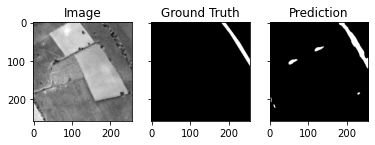

<Figure size 432x288 with 0 Axes>

Saving patch_69_id_1447.tif


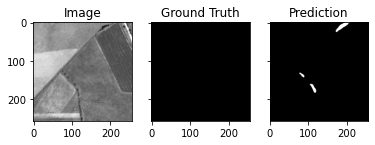

<Figure size 432x288 with 0 Axes>

Saving patch_70_id_1382.tif


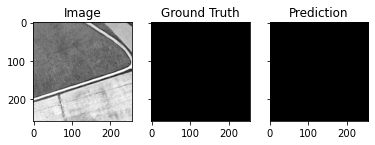

<Figure size 432x288 with 0 Axes>

Saving patch_71_id_1977.tif


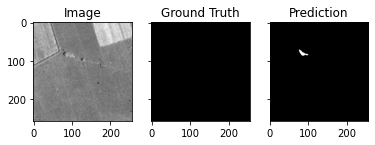

<Figure size 432x288 with 0 Axes>

Saving patch_72_id_1855.tif


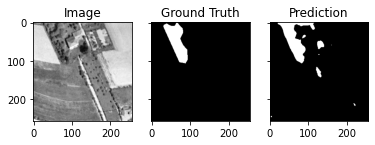

<Figure size 432x288 with 0 Axes>

Saving patch_73_id_1849.tif


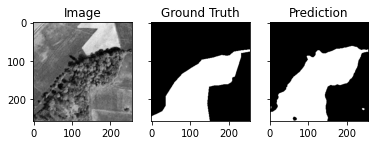

<Figure size 432x288 with 0 Axes>

Saving patch_74_id_1376.tif


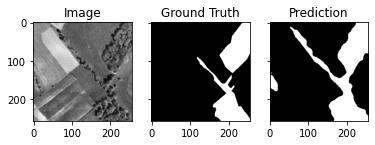

<Figure size 432x288 with 0 Axes>

Saving patch_75_id_1312.tif


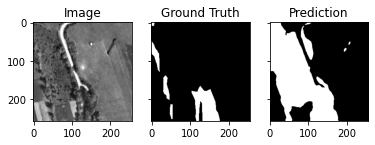

<Figure size 432x288 with 0 Axes>

Saving patch_76_id_1519.tif


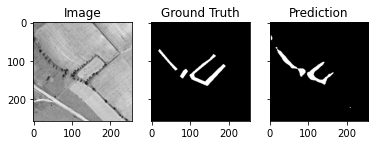

<Figure size 432x288 with 0 Axes>

Saving patch_77_id_1910.tif


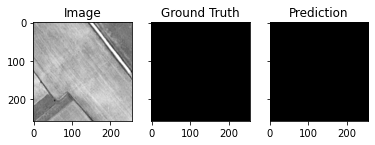

<Figure size 432x288 with 0 Axes>

Saving patch_78_id_1843.tif


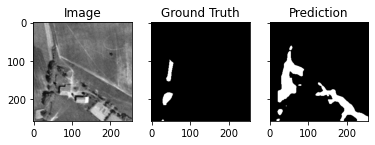

<Figure size 432x288 with 0 Axes>

Saving patch_79_id_1520.tif


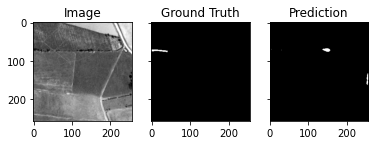

<Figure size 432x288 with 0 Axes>

Saving patch_80_id_1377.tif


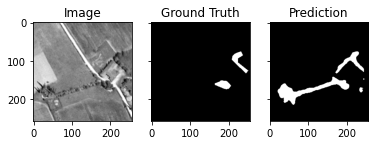

<Figure size 432x288 with 0 Axes>

Saving patch_81_id_1714.tif


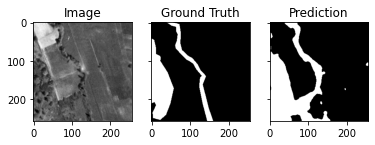

<Figure size 432x288 with 0 Axes>

Saving patch_82_id_1577.tif


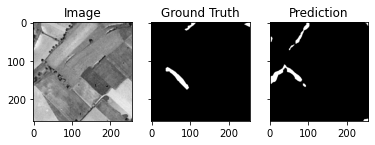

<Figure size 432x288 with 0 Axes>

Saving patch_83_id_2124.tif


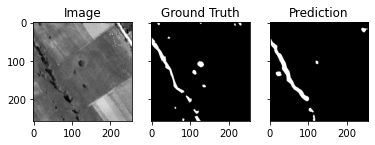

<Figure size 432x288 with 0 Axes>

Saving patch_84_id_1648.tif


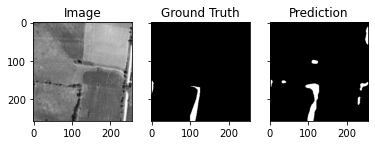

<Figure size 432x288 with 0 Axes>

Saving patch_85_id_1385.tif


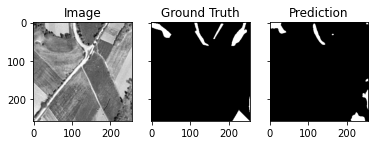

<Figure size 432x288 with 0 Axes>

Saving patch_86_id_2125.tif


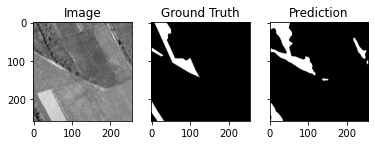

<Figure size 432x288 with 0 Axes>

Saving patch_87_id_1710.tif


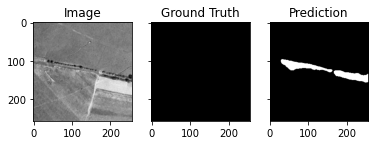

<Figure size 432x288 with 0 Axes>

Saving patch_88_id_1314.tif


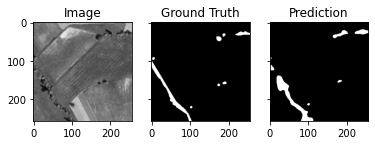

<Figure size 432x288 with 0 Axes>

Saving patch_89_id_1448.tif


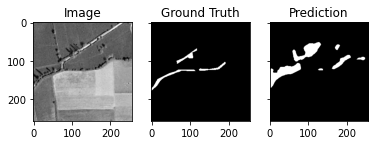

<Figure size 432x288 with 0 Axes>

Saving patch_90_id_1988.tif


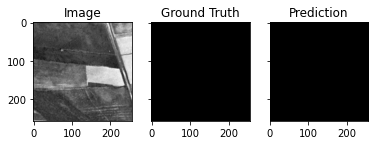

<Figure size 432x288 with 0 Axes>

Saving patch_91_id_1444.tif


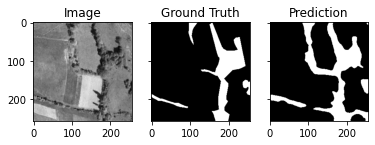

<Figure size 432x288 with 0 Axes>

Saving patch_92_id_1384.tif


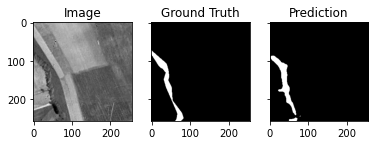

<Figure size 432x288 with 0 Axes>

Saving patch_93_id_1583.tif


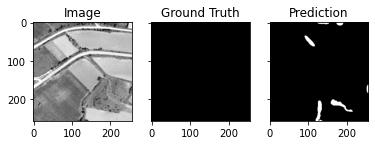

<Figure size 432x288 with 0 Axes>

Saving patch_94_id_2256.tif


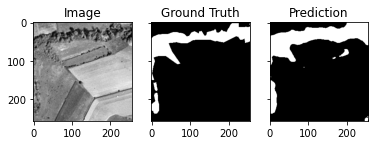

<Figure size 432x288 with 0 Axes>

Saving patch_95_id_2055.tif


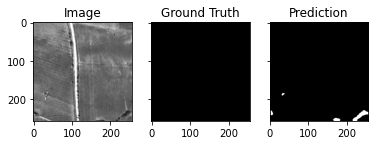

<Figure size 432x288 with 0 Axes>

Saving patch_96_id_1517.tif


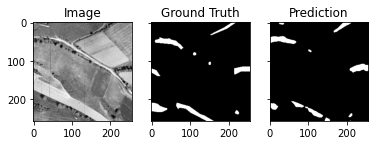

<Figure size 432x288 with 0 Axes>

Saving patch_97_id_2120.tif


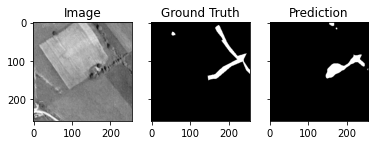

<Figure size 432x288 with 0 Axes>

Saving patch_98_id_1779.tif


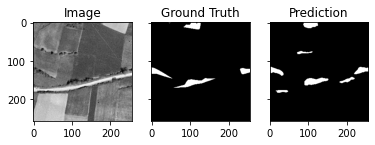

<Figure size 432x288 with 0 Axes>

Saving patch_99_id_2259.tif


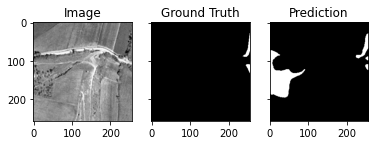

<Figure size 432x288 with 0 Axes>

Saving patch_100_id_1990.tif


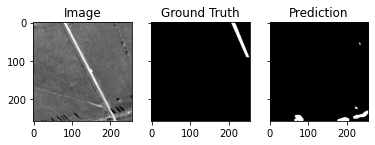

<Figure size 432x288 with 0 Axes>

Saving patch_101_id_2045.tif


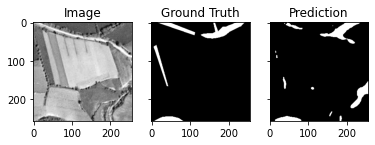

<Figure size 432x288 with 0 Axes>

Saving patch_102_id_1989.tif


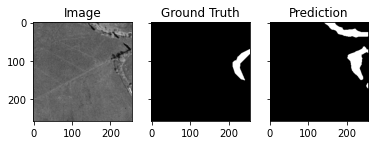

<Figure size 432x288 with 0 Axes>

Saving patch_103_id_2115.tif


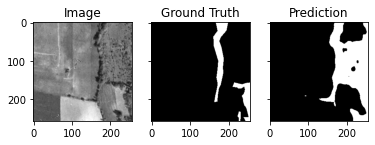

<Figure size 432x288 with 0 Axes>

Saving patch_104_id_1451.tif


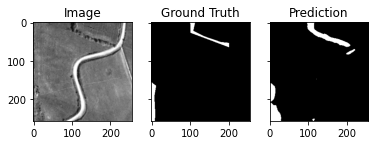

<Figure size 432x288 with 0 Axes>

Saving patch_105_id_1452.tif


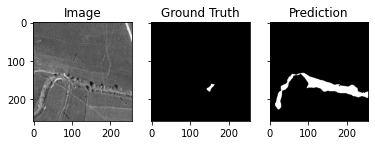

<Figure size 432x288 with 0 Axes>

Saving patch_106_id_1857.tif


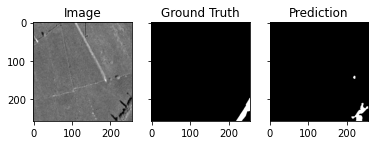

<Figure size 432x288 with 0 Axes>

Saving patch_107_id_1919.tif


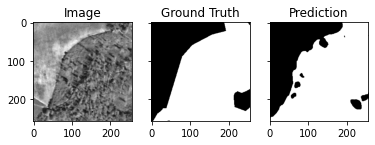

<Figure size 432x288 with 0 Axes>

Saving patch_108_id_1521.tif


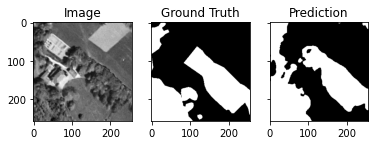

<Figure size 432x288 with 0 Axes>

Saving patch_109_id_1587.tif


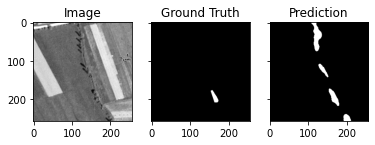

<Figure size 432x288 with 0 Axes>

Saving patch_110_id_1853.tif


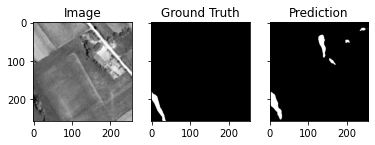

<Figure size 432x288 with 0 Axes>

Saving patch_111_id_1716.tif


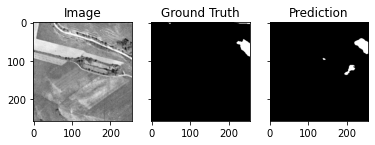

<Figure size 432x288 with 0 Axes>

Saving patch_112_id_2248.tif


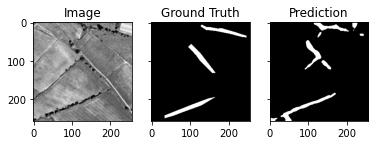

<Figure size 432x288 with 0 Axes>

Saving patch_113_id_2253.tif


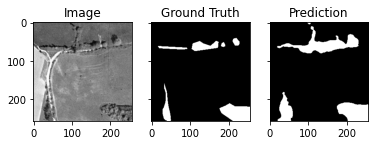

<Figure size 432x288 with 0 Axes>

Saving patch_114_id_2181.tif


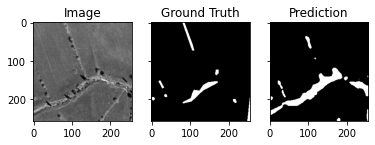

<Figure size 432x288 with 0 Axes>

Saving patch_115_id_2046.tif


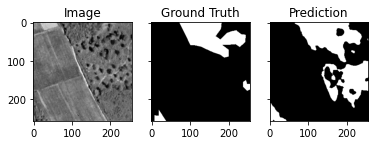

<Figure size 432x288 with 0 Axes>

Saving patch_116_id_1643.tif


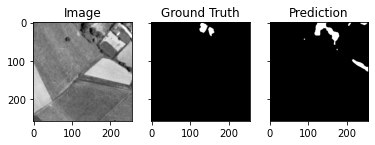

<Figure size 432x288 with 0 Axes>

Saving patch_117_id_1651.tif


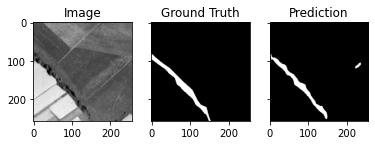

<Figure size 432x288 with 0 Axes>

Saving patch_118_id_1718.tif


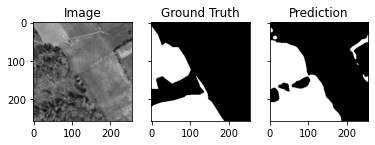

<Figure size 432x288 with 0 Axes>

Saving patch_119_id_1522.tif


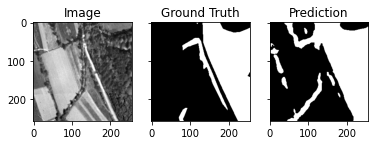

<Figure size 432x288 with 0 Axes>

Saving patch_120_id_1586.tif


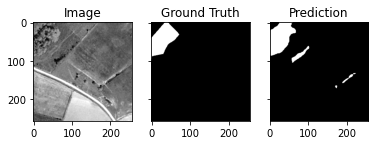

<Figure size 432x288 with 0 Axes>

Saving patch_121_id_1310.tif


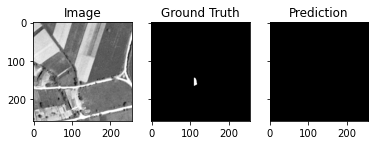

<Figure size 432x288 with 0 Axes>

Saving patch_122_id_1786.tif


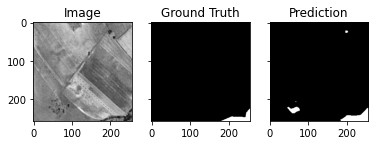

<Figure size 432x288 with 0 Axes>

Saving patch_123_id_2250.tif


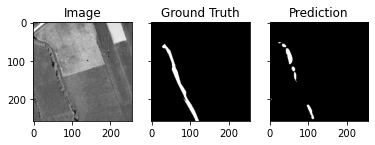

<Figure size 432x288 with 0 Axes>

Saving patch_124_id_1789.tif


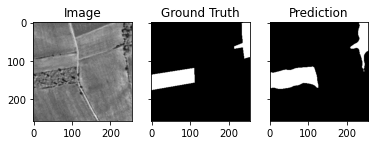

<Figure size 432x288 with 0 Axes>

Saving patch_125_id_1388.tif


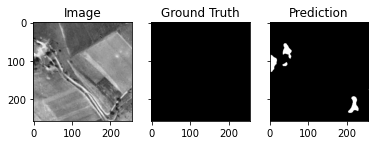

<Figure size 432x288 with 0 Axes>

Saving patch_126_id_1508.tif


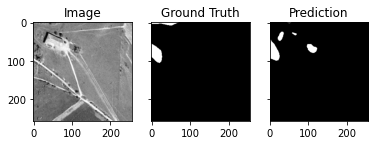

<Figure size 432x288 with 0 Axes>

Saving patch_127_id_2249.tif


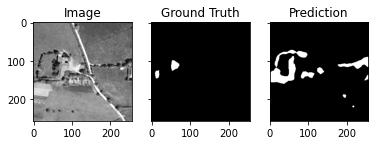

<Figure size 432x288 with 0 Axes>

Saving patch_128_id_1315.tif


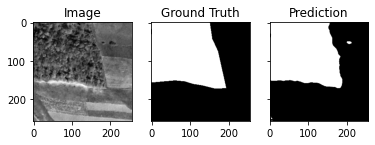

<Figure size 432x288 with 0 Axes>

Saving patch_129_id_1443.tif


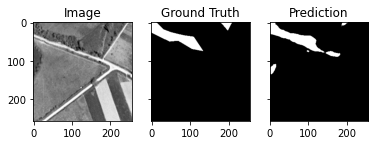

<Figure size 432x288 with 0 Axes>

Saving patch_130_id_1722.tif


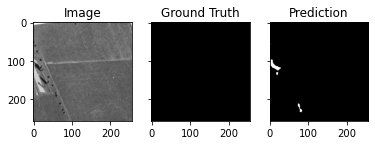

<Figure size 432x288 with 0 Axes>

Saving patch_131_id_1917.tif


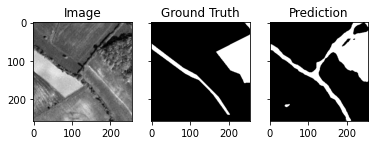

<Figure size 432x288 with 0 Axes>

Saving patch_132_id_1442.tif


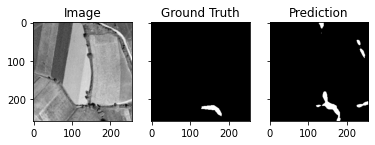

<Figure size 432x288 with 0 Axes>

Saving patch_133_id_2118.tif


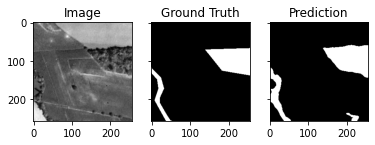

<Figure size 432x288 with 0 Axes>

Saving patch_134_id_1510.tif


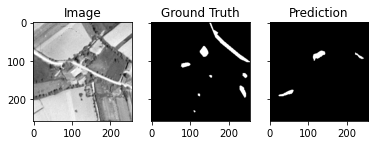

<Figure size 432x288 with 0 Axes>

Saving patch_135_id_1785.tif


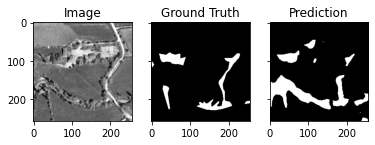

<Figure size 432x288 with 0 Axes>

Saving patch_136_id_1921.tif


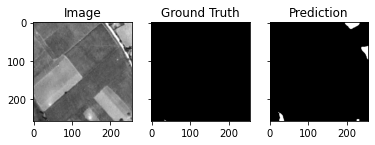

<Figure size 432x288 with 0 Axes>

Saving patch_137_id_1513.tif


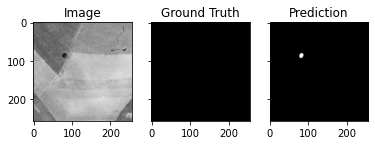

<Figure size 432x288 with 0 Axes>

Saving patch_138_id_1381.tif


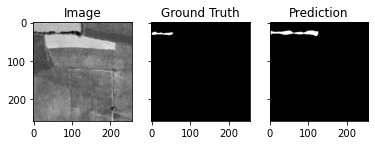

<Figure size 432x288 with 0 Axes>

Saving patch_139_id_1449.tif


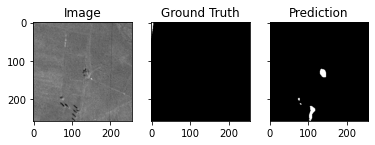

<Figure size 432x288 with 0 Axes>

Saving patch_140_id_2114.tif


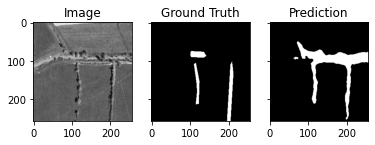

<Figure size 432x288 with 0 Axes>

Saving patch_141_id_2050.tif


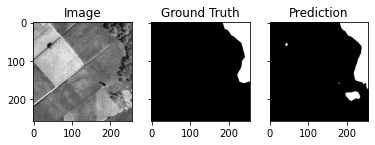

<Figure size 432x288 with 0 Axes>

Saving patch_142_id_1379.tif


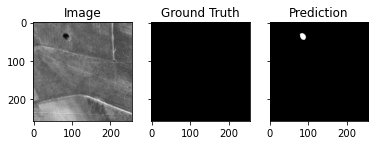

<Figure size 432x288 with 0 Axes>

Saving patch_143_id_1516.tif


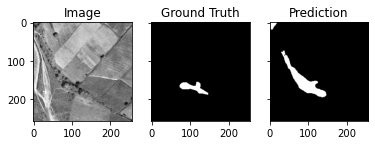

<Figure size 432x288 with 0 Axes>

Saving patch_144_id_2252.tif


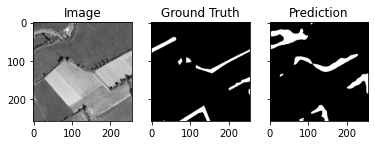

<Figure size 432x288 with 0 Axes>

Saving patch_145_id_2116.tif


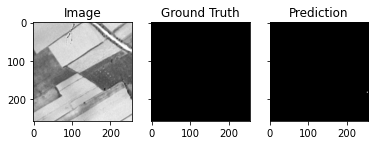

<Figure size 432x288 with 0 Axes>

Saving patch_146_id_1784.tif


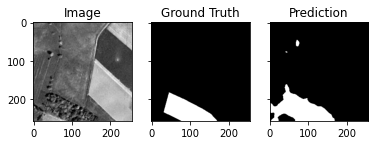

<Figure size 432x288 with 0 Axes>

Saving patch_147_id_1308.tif


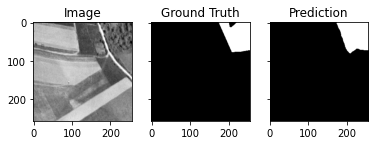

<Figure size 432x288 with 0 Axes>

Saving patch_148_id_1646.tif


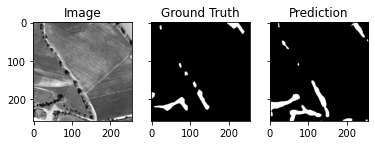

<Figure size 432x288 with 0 Axes>

Saving patch_149_id_2190.tif


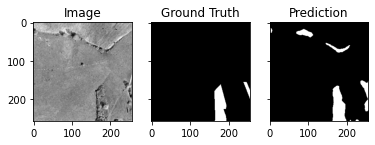

<Figure size 432x288 with 0 Axes>

Saving patch_150_id_2245.tif


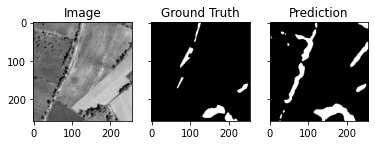

<Figure size 432x288 with 0 Axes>

Saving patch_151_id_2123.tif


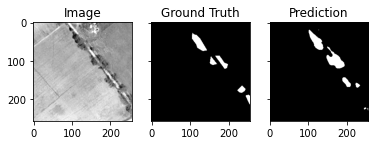

<Figure size 432x288 with 0 Axes>

Saving patch_152_id_1911.tif


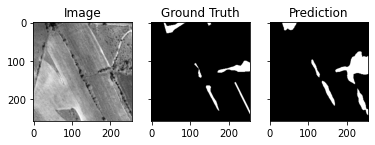

<Figure size 432x288 with 0 Axes>

Saving patch_153_id_2183.tif


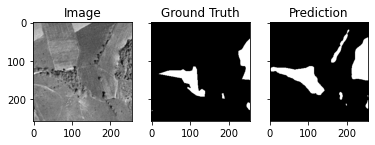

<Figure size 432x288 with 0 Axes>

Saving patch_154_id_2054.tif


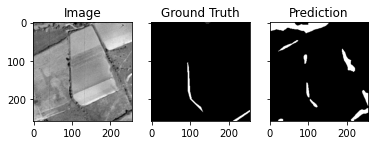

<Figure size 432x288 with 0 Axes>

Saving patch_155_id_2053.tif


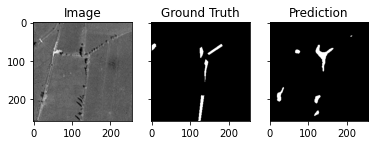

<Figure size 432x288 with 0 Axes>

Saving patch_156_id_1924.tif


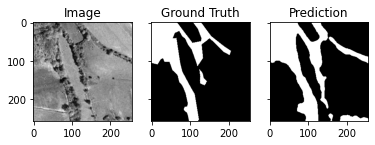

<Figure size 432x288 with 0 Axes>

Saving patch_157_id_1317.tif


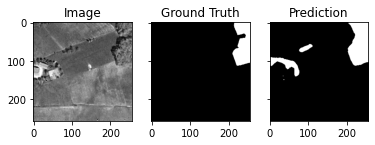

<Figure size 432x288 with 0 Axes>

Saving patch_158_id_1316.tif


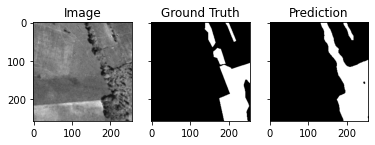

<Figure size 432x288 with 0 Axes>

Saving patch_159_id_1454.tif


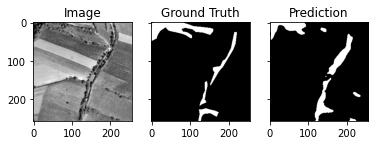

<Figure size 432x288 with 0 Axes>

Saving patch_160_id_2056.tif


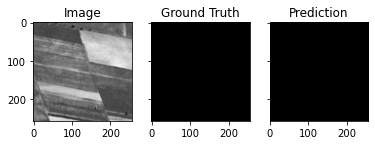

<Figure size 432x288 with 0 Axes>

Saving patch_161_id_1578.tif


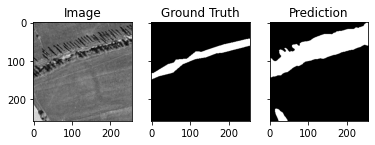

<Figure size 432x288 with 0 Axes>

Saving patch_162_id_2111.tif


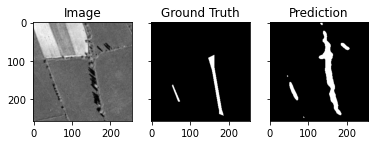

<Figure size 432x288 with 0 Axes>

Saving patch_163_id_1918.tif


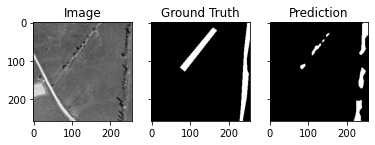

<Figure size 432x288 with 0 Axes>

Saving patch_164_id_2113.tif


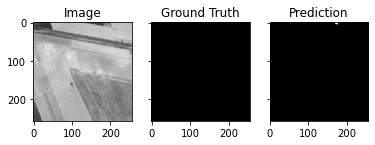

<Figure size 432x288 with 0 Axes>

Saving patch_165_id_1645.tif


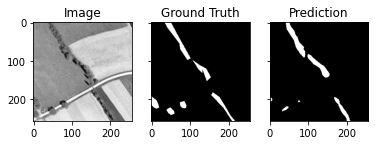

<Figure size 432x288 with 0 Axes>

Saving patch_166_id_1912.tif


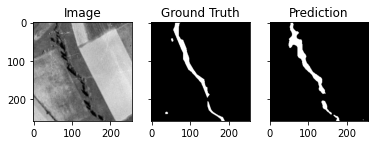

<Figure size 432x288 with 0 Axes>

In [ ]:
# set the model in evaluation model
BEST_MODEL = '../best_model/unet'
best_iou_model = glob.glob(BEST_MODEL + '/*.pth')[0]
# best_iou_model = [i for i in best_iou_model if i.startswith(data_portion, 14)][1]
print(best_iou_model)
folder = '../saved_images'

model_ = model.unet_model.to(config.DEVICE)
model_.load_state_dict(torch.load(best_iou_model))

y_hat, y_true, y_score = train_val_test.make_predictions(model_, test_dataloader, X_test, folder, print_pred=True, save_patches=True)

In [ ]:
labels = [0,1]
target_names = ['Non-trees', 'Trees']
metrics.cm_analysis(y_true, y_hat, labels, target_names)

In [251]:
preds = glob.glob('../saved_images/masks'  + '/*.tif')

mosaic, proj = utis.raster_mosaic(preds)

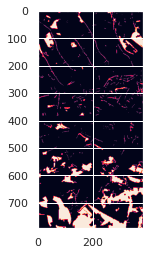

In [252]:
# missing to save to disk
plt.imshow(mosaic[0][::10,::10])

In [30]:
# # set the model in evaluation model
# BEST_MODEL = '../best_model'
# best_iou_model = glob.glob(BEST_MODEL + '/*.pth')
# best_iou_model.sort()
# portions = ['coarse_plus_fine_labels', 'coarse_labels', 'fine_labels']
# portions.sort()
# folder = '../saved_images'

# for i, p in zip(best_iou_model, portions):
#     # load the model 
#     model_ = model.unet_model.to(config.DEVICE)
#     model_.load_state_dict(torch.load(i))
    
#     y_hat, y_true, y_score = train_val_test.make_predictions(model_, test_dataloader, X_test, folder, print_pred=False)
#     y_hat, y_true, y_score = y_hat.detach().cpu().numpy(), y_true.detach().cpu().numpy(), y_score.detach().cpu().numpy()
    
#     fpr, tpr, thresholds = roc_curve(y_true, y_score)
#     roc_auc = auc(fpr, tpr)

#     lw = 2
#     plt.plot([0, 1], [0, 1], color='navy', linestyle='--', alpha=0.15)
#     plt.plot(fpr, tpr, lw=lw, label=f'{p} (area = {roc_auc: 0.4f})')

#     plt.xlabel('Specificity - False Positive Rate')
#     plt.ylabel('Sensitivity - True Positive Rate')
#     plt.title(f'ROC')
#     plt.legend(loc="lower right")